# Downloading images from LAION-5B

LAION-5B is a dataset with 5 billion image/text pairs.

It has been indexed using CLIP and can be queried using text/images.

Goal:
* Download 100 images for each of the classes in FoodVision.
* See how good these images are to use as a dataset for future models.
* Increase the number of images downloaded if they are good quality.

Resources:
* See the code on GitHub: https://github.com/rom1504/clip-retrieval 
* See the blog post: https://laion.ai/blog/h14_clip_retrieval/ 
* See the demo: https://rom1504.github.io/clip-retrieval/?back=https%3A%2F%2Fknn.laion.ai&index=laion5B-H-14&useMclip=false&query=salt+shaker+photo 
* Example notebook: https://github.com/rom1504/clip-retrieval/blob/main/notebook/clip-client-query-api.ipynb 

## Try downloading images for a single class

In [1]:
from clip_retrieval.clip_client import ClipClient, Modality

client = ClipClient(url="https://knn.laion.ai/knn-service", 
                    indice_name="laion5B-H-14", # H = Huge, L = Large (huge is bigger than large)
                    num_images=100)

/home/daniel/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/daniel/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowIlEET_S2_S2_b
  warn(f"Failed to load image Python extension: {e}")


In [13]:
results = client.query(text="salt shaker photo")
results[0]

{'url': 'https://diabetesdietblogdotcom.files.wordpress.com/2016/03/salt_shaker_on_white_background.jpg?w=610',
 'caption': 'Salt_shaker_on_white_background',
 'id': 3637752355,
 'similarity': 0.40506356954574585}

In [14]:
# Save results to JSON file
import json
with open("clip_retrieval_results.json", "w") as f:
    json.dump(results, f)

## Download images

Going to download the resulting images with `img2dataset`, see the GitHub here: https://github.com/rom1504/img2dataset

In [16]:
!img2dataset "clip_retrieval_results.json" --input_format="json" --caption_col "caption" --output_folder="clip_retrieval_results" --resize_mode="no" --output_format="files"

Starting the downloading of this file
Sharding file number 1 of 1 called /home/daniel/code/nutrify/foodvision/notebooks/clip_retrieval_results.json
0it [00:00, ?it/s]File sharded in 1 shards
1it [00:09,  9.72s/it]
worker  - success: 0.881 - failed to download: 0.119 - failed to resize: 0.000 - images per sec: 5 - count: 42
total   - success: 0.881 - failed to download: 0.119 - failed to resize: 0.000 - images per sec: 5 - count: 42


In [15]:
# !rm -rf clip_retrieval_results/*

In [5]:
# List how many images are in clip_retrieval_results folder
!ls -l clip_retrieval_results | wc -l

4


## Get class names from labels

In [2]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from pathlib import Path

In [3]:
# Get config
from configs.default_config import config

args = config
print(args)

# Connect to GCP
from utils.gcp_utils import set_gcp_credentials, test_gcp_connection
set_gcp_credentials(path_to_key="../utils/google-storage-key.json")
test_gcp_connection()

import wandb

# Initialize a new run
from utils.wandb_utils import wandb_load_artifact, wandb_download_and_load_labels

run = wandb.init(project=args.wandb_project, 
                 job_type=args.wandb_job_type,
                 tags=['internet_image_download'],
                 notes="download ~100x images per class using clip-retrieval")

annotations, class_names, class_dict, reverse_class_dict, labels_path = wandb_download_and_load_labels(wandb_run=run,
wandb_labels_artifact_name=args.wandb_labels_artifact)

namespace(annotations_columns_to_export=['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source'], auto_augment=True, batch_size=128, epochs=10, gs_bucket_name='food_vision_bucket_with_object_versioning', gs_image_storage_path='https://storage.cloud.google.com/food_vision_bucket_with_object_versioning/all_images/', input_size=224, label_smoothing=0.1, learning_rate=0.001, model='coatnext_nano_rw_224', num_to_try_and_autocorrect=1000, path_to_gcp_credentials='utils/google-storage-key.json', path_to_label_studio_api_key='utils/label_studio_api_key.json', pretrained=True, seed=42, use_mixed_precision=True, wandb_dataset_artifact='food_vision_199_classes_images:latest', wandb_job_type='', wandb_labels_artifact='food_vision_labels:latest', wandb_model_artifact='trained_model:latest', wandb_project='test_wandb_artifacts_by_reference', wandb_run_notes='', wandb_run_tag

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrdbourke. Use `wandb login --relogin` to force relogin


[INFO] Labels directory: ./artifacts/food_vision_labels:v22
[INFO] Labels path: artifacts/food_vision_labels:v22/annotations.csv
[INFO] Working with: 204 classes


In [4]:
class_names[:10]

['almond_butter',
 'almonds',
 'apple_green',
 'apple_red',
 'apricot',
 'asparagus',
 'avocado',
 'bacon',
 'bacon_and_egg_burger',
 'bagel']

### Loop through class names and download ~100 images per class

In [21]:
from clip_retrieval.clip_client import ClipClient, Modality

client = ClipClient(url="https://knn.laion.ai/knn-service", 
                    indice_name="laion5B-H-14", # H = Huge, L = Large (huge is bigger than large)
                    num_images=100)

In [28]:
from tqdm.auto import tqdm

combined_results = []
for class_name in tqdm(class_names):
    results = client.query(text=f"{class_name} (food) photo")
    for result in results:
    # print(results)
        result["class_name"] = class_name
        result["label"] = reverse_class_dict[class_name]
    combined_results.extend(results)

len(combined_results)

  0%|          | 0/199 [00:00<?, ?it/s]

13343

In [34]:
# Select a random result
import random
random.choice(combined_results)
# combined_results[0]

{'url': 'https://ais.kochbar.de/kbrezept/503738_843721/400x266/fleisch-kaese-strudel-rezept.jpg',
 'caption': 'Rezept: Fleisch Käse Strudel',
 'id': 2796819674,
 'similarity': 0.37485966086387634,
 'class_name': 'sausage_roll',
 'label': 167}

In [37]:
combined_results[0]

{'url': 'https://thumbnail.image.rakuten.co.jp/@0_mall/rtor/cabinet/00770170/imgrc0070055155.jpg?_ex=300x300',
 'caption': 'カークランド【クリーミーアーモンドバター 765g入り】アーモンド100%/大容量/たっぷり/KS',
 'id': 4226929696,
 'similarity': 0.3932535946369171,
 'class_name': 'almond_butter',
 'label': 0}

In [35]:
# Save results to JSON
import json

# Get current timestamp
from utils.misc import get_now_time
now = get_now_time()

save_path = f"{now}_clip_retrieval_100_images_per_class.json"

with open(save_path, "w") as f:
    json.dump(combined_results, f)

In [36]:
# Download results to local machine
# Path 2023-02-07_15-43-32_clip_retrieval_100_images_per_class.json
!img2dataset "2023-02-07_15-43-32_clip_retrieval_100_images_per_class.json" --input_format="json" --caption_col "caption" --output_folder="2023_02_07_clip_retrieval_100_images_per_class" --resize_mode="no" --output_format="files"

Starting the downloading of this file
Sharding file number 1 of 1 called /home/daniel/code/nutrify/foodvision/notebooks/2023-02-07_15-43-32_clip_retrieval_100_images_per_class.json
0it [00:00, ?it/s]File sharded in 2 shards
1it [01:31, 91.30s/it]worker  - success: 0.908 - failed to download: 0.084 - failed to resize: 0.008 - images per sec: 112 - count: 10000
total   - success: 0.908 - failed to download: 0.084 - failed to resize: 0.008 - images per sec: 112 - count: 10000
2it [02:11, 65.79s/it]
worker  - success: 0.903 - failed to download: 0.083 - failed to resize: 0.014 - images per sec: 83 - count: 3343
total   - success: 0.907 - failed to download: 0.084 - failed to resize: 0.010 - images per sec: 103 - count: 13343


In [ ]:
# Next:
# Go through downloaded images and label them with their appropriate class (they can be matched via their URL)
# Add a UUID to each image 
# Create labels for images in same style as FoodVision labels
# Make an image source tag for where the images came from
# Upload to GCP as all training images (can swap 20% to test set later)
# Track updated labels and images in Weights & Biases
# Train a model with and without new images (on unmodified test set)

In [38]:
# Check the file size of 2023_02_07_clip_retrieval_100_images_per_class.json in MB
!ls -lh /home/daniel/code/nutrify/foodvision/notebooks/2023-02-07_15-43-32_clip_retrieval_100_images_per_class.json

-rw-rw-r-- 1 daniel daniel 3.7M Feb  7 15:43 /home/daniel/code/nutrify/foodvision/notebooks/2023-02-07_15-43-32_clip_retrieval_100_images_per_class.json


In [6]:
# Read in the file and explore it
import json

with open("2023-02-07_15-43-32_clip_retrieval_100_images_per_class.json", "r") as f:
    results = json.load(f)

results[0]


{'url': 'https://thumbnail.image.rakuten.co.jp/@0_mall/rtor/cabinet/00770170/imgrc0070055155.jpg?_ex=300x300',
 'caption': 'カークランド【クリーミーアーモンドバター 765g入り】アーモンド100%/大容量/たっぷり/KS',
 'id': 4226929696,
 'similarity': 0.3932535946369171,
 'class_name': 'almond_butter',
 'label': 0}

In [7]:
len(results)

13343

In [10]:
target_dir = "2023_02_07_clip_retrieval_100_images_per_class"

# Get a list of all .JSON files in target_dir
import glob
json_files = glob.glob(f"{target_dir}/*/*.json")
len(json_files)

12097

In [11]:
# Open each .JSON file and append it to a list
import json
all_json = []
for json_file in json_files:
    with open(json_file, "r") as f:
        json_data = json.load(f)
        all_json.append(json_data)
len(all_json)

12097

In [14]:
all_json[0]

{'caption': 'Pizzeria Bar アドレス',
 'url': 'http://r.gnavi.co.jp/g736303/img/g736303t.jpg',
 'key': '000009009',
 'status': 'success',
 'error_message': None,
 'width': 64,
 'height': 64,
 'original_width': 64,
 'original_height': 64,
 'exif': '{}',
 'sha256': 'bd0da08267ec9a6eff47412a99d8721e28eb19db31ef55648cc49fde397a5a62'}

In [16]:
# Loop through all_json and match the URL to the URL in the results list

for result in results:
    for json_data in all_json:
        if result["url"] == json_data["url"]:
            result["json_data"] = json_data
            break

In [17]:
results[0]

{'url': 'https://thumbnail.image.rakuten.co.jp/@0_mall/rtor/cabinet/00770170/imgrc0070055155.jpg?_ex=300x300',
 'caption': 'カークランド【クリーミーアーモンドバター 765g入り】アーモンド100%/大容量/たっぷり/KS',
 'id': 4226929696,
 'similarity': 0.3932535946369171,
 'class_name': 'almond_butter',
 'label': 0,
 'json_data': {'caption': 'カークランド【クリーミーアーモンドバター 765g入り】アーモンド100%/大容量/たっぷり/KS',
  'url': 'https://thumbnail.image.rakuten.co.jp/@0_mall/rtor/cabinet/00770170/imgrc0070055155.jpg?_ex=300x300',
  'key': '000000000',
  'status': 'success',
  'error_message': None,
  'width': 154,
  'height': 300,
  'original_width': 154,
  'original_height': 300,
  'exif': '{}',
  'sha256': 'bc16de53845c3446b7da6137c8f06d977920b427a8102da1e37aa5eb4f906b00'}}

In [20]:
# Get all the image paths
import glob
image_files = glob.glob(f"{target_dir}/*/*.jpg")
image_files[:10], len(image_files)

(['2023_02_07_clip_retrieval_100_images_per_class/00000/000007771.jpg',
  '2023_02_07_clip_retrieval_100_images_per_class/00000/000004502.jpg',
  '2023_02_07_clip_retrieval_100_images_per_class/00000/000004004.jpg',
  '2023_02_07_clip_retrieval_100_images_per_class/00000/000007567.jpg',
  '2023_02_07_clip_retrieval_100_images_per_class/00000/000002676.jpg',
  '2023_02_07_clip_retrieval_100_images_per_class/00000/000005185.jpg',
  '2023_02_07_clip_retrieval_100_images_per_class/00000/000003561.jpg',
  '2023_02_07_clip_retrieval_100_images_per_class/00000/000002688.jpg',
  '2023_02_07_clip_retrieval_100_images_per_class/00000/000007582.jpg',
  '2023_02_07_clip_retrieval_100_images_per_class/00000/000006721.jpg'],
 12097)

In [21]:
# Got through the results and if the json_data key exists, add the image path to the result
for result in results:
    if "json_data" in result:
        for image_file in image_files:
            if result["json_data"]["key"] == image_file.split("/")[-1].split(".")[0]:
                result["image_path"] = image_file
                break

In [22]:
results[:3]

[{'url': 'https://thumbnail.image.rakuten.co.jp/@0_mall/rtor/cabinet/00770170/imgrc0070055155.jpg?_ex=300x300',
  'caption': 'カークランド【クリーミーアーモンドバター 765g入り】アーモンド100%/大容量/たっぷり/KS',
  'id': 4226929696,
  'similarity': 0.3932535946369171,
  'class_name': 'almond_butter',
  'label': 0,
  'json_data': {'caption': 'カークランド【クリーミーアーモンドバター 765g入り】アーモンド100%/大容量/たっぷり/KS',
   'url': 'https://thumbnail.image.rakuten.co.jp/@0_mall/rtor/cabinet/00770170/imgrc0070055155.jpg?_ex=300x300',
   'key': '000000000',
   'status': 'success',
   'error_message': None,
   'width': 154,
   'height': 300,
   'original_width': 154,
   'original_height': 300,
   'exif': '{}',
   'sha256': 'bc16de53845c3446b7da6137c8f06d977920b427a8102da1e37aa5eb4f906b00'},
  'image_path': '2023_02_07_clip_retrieval_100_images_per_class/00000/000000000.jpg'},
 {'url': 'https://rawkinmom.files.wordpress.com/2012/03/s2250046.jpg',
  'caption': 'Now you have fresh homemade almond butter so make this recipe……..',
  'id': 424039970,
  'simi

In [66]:
# Create a subset of results where image_path is not None
results_with_image_path = [result for result in results if "image_path" in result]
len(results_with_image_path)

12101

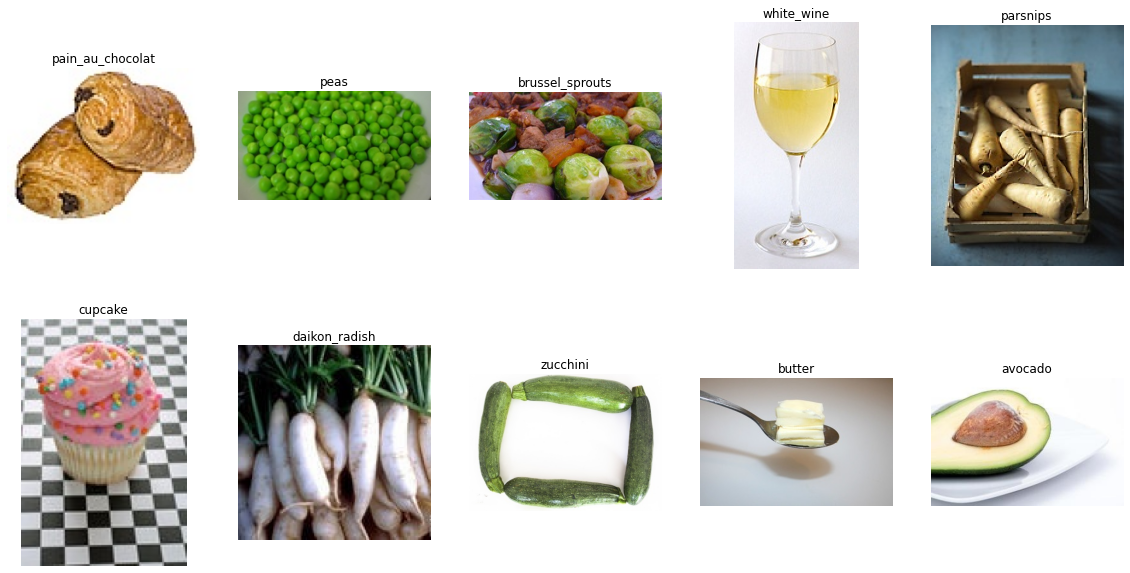

In [71]:
# Plot 10 random images from results with the class_name as the title
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    result = random.choice(results_with_image_path)
    ax.imshow(plt.imread(result["image_path"]))
    ax.set_title(result["class_name"])
    ax.axis("off")

In [72]:
# Turn results into a dataframe
import pandas as pd
df = pd.DataFrame(results_with_image_path)
df.head()

url  \
0  https://thumbnail.image.rakuten.co.jp/@0_mall/...   
1  https://rawkinmom.files.wordpress.com/2012/03/...   
2  https://fthmb.tqn.com/7H4siYXQ0qX-PaxUjLvZpDlz...   
3  https://www.drsosha.com/wp-content/uploads/201...   
4  https://runningoncloud9.files.wordpress.com/20...   

                                             caption          id  similarity  \
0  カークランド【クリーミーアーモンドバター 765g入り】アーモンド100%/大容量/たっぷり/KS  4226929696    0.393254   
1  Now you have fresh homemade almond butter so m...   424039970    0.392245   
2                   Almond-butter-Only_Creatives.jpg  3576358489    0.390147   
3  کره بادامزمینی و بادام بهترین تنقلات برای افرا...  3982123287    0.388856   
4                MaraNatha Almond Butter from Costco  1790041740    0.388502   

      class_name  label                                          json_data  \
0  almond_butter      0  {'caption': 'カークランド【クリーミーアーモンドバター 765g入り】アーモンド...   
1  almond_butter      0  {'caption': 'Now you have fresh homemade almon...   
2  almond_butter      0  {'caption': 'Almond-butter-Only_Creatives.jpg'...   
3  almond_butter      0  {'caption': 'کره بادامزمینی و بادام بهترین تنق...   
4  almond_butter      0  {'caption': 'MaraNatha Almond Butter from Cost...   

                                          image_path  
0  2023_02_07_clip_retrieval_100_images_per_class...  
1  2023_02_07_clip_retrieval_100_images_per_class...  
2  2023_02_07_clip_retrieval_100_images_per_class...  
3  2023_02_07_clip_retrieval_100_images_per_class...  
4  2023_02_07_clip_retrieval_100_images_per_class...

In [73]:
# Find the unqiue class_names in the dataframe
unique_class_names = list(df["class_name"].unique())

# Find all the class_names that have "onion" in them
onion_class_names = [class_name for class_name in unique_class_names if "onion" in class_name]
onion_class_names

['green_onion', 'onion', 'red_onion', 'white_onion']

In [74]:
# Missing classes
list(set(class_names) - set(unique_class_names))

['apple_green',
 'onion_red',
 'onion_green',
 'apple_red',
 'bread_naan',
 'lychee',
 'onion_brown',
 'curry_chicken',
 'potato_white',
 'onion_white',
 'potato_brown']

In [75]:
# NEXT 
# Rename classes to match FoodVision classes (e.g. potatoes -> brown_potato)
class_name_changes = {"potatoes": "potato_brown",
                      "onion": "onion_brown",
                      "red_onion": "onion_red",
                      "white_onion": "onion_white",
                      "green_onion": "onion_green",
                      "apple": "apple_red"}

In [76]:
# Rename all of the class_names in the dataframe to match class_name_changes
df["class_name"] = df["class_name"].replace(class_name_changes)
sorted(list(df["class_name"].unique()))

['almond_butter',
 'almonds',
 'apple_red',
 'apricot',
 'asparagus',
 'avocado',
 'bacon',
 'bacon_and_egg_burger',
 'bagel',
 'baklava',
 'banana',
 'banana_bread',
 'barbecue_sauce',
 'beans',
 'beef',
 'beef_curry',
 'beef_mince',
 'beef_stir_fry',
 'beer',
 'beetroot',
 'biltong',
 'blackberries',
 'blueberries',
 'bok_choy',
 'bread',
 'broccoli',
 'broccolini',
 'brownie',
 'brussel_sprouts',
 'burrito',
 'butter',
 'cabbage',
 'calamari',
 'candy',
 'capsicum',
 'carrot',
 'cashews',
 'cauliflower',
 'celery',
 'cheese',
 'cheeseburger',
 'cherries',
 'chicken_breast',
 'chicken_thighs',
 'chicken_wings',
 'chilli',
 'chimichurri',
 'chocolate',
 'chocolate_cake',
 'coconut',
 'coffee',
 'coleslaw',
 'cookies',
 'coriander',
 'corn',
 'corn_chips',
 'cream',
 'croissant',
 'crumbed_chicken',
 'cucumber',
 'cupcake',
 'daikon_radish',
 'dates',
 'donuts',
 'dragonfruit',
 'eggplant',
 'eggs',
 'enoki_mushroom',
 'fennel',
 'figs',
 'french_toast',
 'fried_rice',
 'fries',
 'frui

In [77]:
updated_class_name_list = sorted(list(df["class_name"].unique()))

# Find all the classes with "onion" in them in the updated class names
updated_onion_class_names = [class_name for class_name in updated_class_name_list if "onion" in class_name]
updated_onion_class_names

['onion_brown', 'onion_green', 'onion_red', 'onion_white']

In [100]:
# Turn the DataFrame into a list of dictionaries
results_list = df.to_dict("records")
len(results_list)

12101

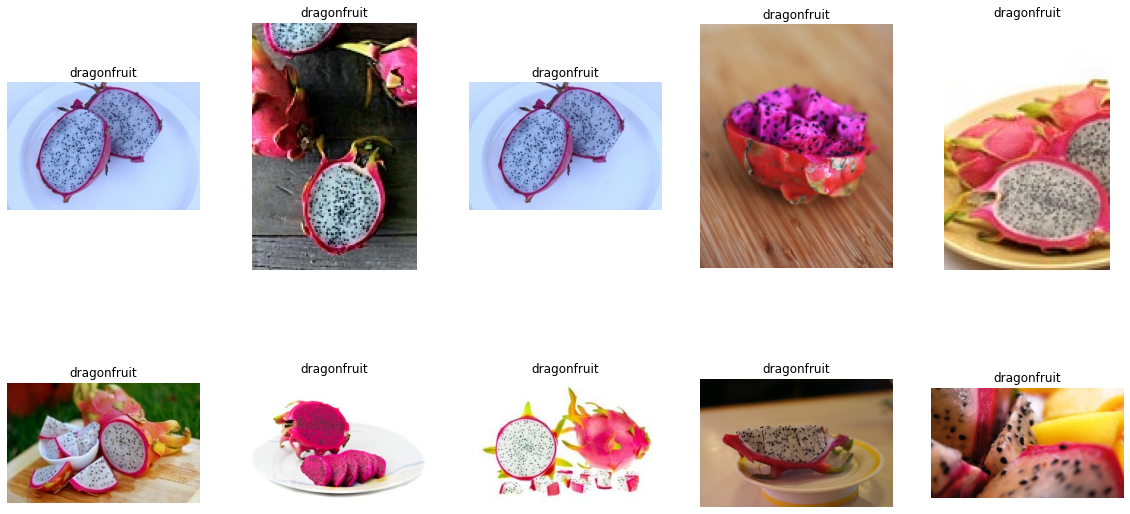

In [101]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
filter = "dragon"
results_list_filter = [result for result in results_list if filter in result["class_name"]]

for i, ax in enumerate(axes.flatten()):    
    result = random.choice(results_list_filter)
    ax.imshow(plt.imread(result["image_path"]))
    ax.set_title(result["class_name"])
    ax.axis("off")

In [102]:
# Get the average size of each image
from PIL import Image
from tqdm.auto import tqdm

image_sizes = []
for result in tqdm(results_list):
    image = Image.open(result["image_path"])
    image_sizes.append(image.size)


  0%|          | 0/12101 [00:00<?, ?it/s]

In [103]:
# Flatten image_sizes into a single list
image_sizes = [size for image_size in image_sizes for size in image_size]
image_sizes[:10]

[154, 300, 1854, 1574, 768, 505, 300, 208, 690, 517]

In [104]:
# Get the statistics about each image
import numpy as np

mean_image_size = np.mean(image_sizes)
median_image_size = np.median(image_sizes)
max_image_size = np.max(image_sizes)
min_image_size = np.min(image_sizes)

print(f"Mean image size: {mean_image_size}")
print(f"Median image size: {median_image_size}")
print(f"Max image size: {max_image_size}")
print(f"Min image size: {min_image_size}")


Mean image size: 324.12784067432443
Median image size: 236.0
Max image size: 6986
Min image size: 1


In [105]:
# Find the average file size for each image
import os

for result in results_list:
    result["file_size_mb"] = os.path.getsize(result["image_path"]) / 1e6

In [106]:
# Get the statistics about each image
import numpy as np

mean_file_size = np.mean([result["file_size_mb"] for result in results_list])
median_file_size = np.median([result["file_size_mb"] for result in results_list])
max_file_size = np.max([result["file_size_mb"] for result in results_list])
min_file_size = np.min([result["file_size_mb"] for result in results_list])

print(f"Mean file size: {mean_file_size}")
print(f"Median file size: {median_file_size}")
print(f"Max file size: {max_file_size}")
print(f"Min file size: {min_file_size}")

Mean file size: 0.04856175555739195
Median file size: 0.020795
Max file size: 7.51256
Min file size: 0.000333


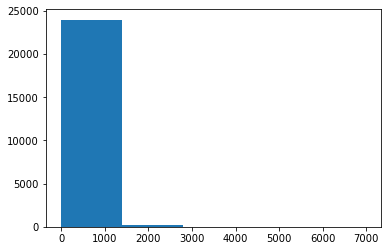

In [107]:
# Plot a histogram of image sizes
plt.hist(image_sizes, bins=5);

## Create labels for images downloaded from LAION-5B

In [108]:
class_names_all = []
for result in results_list:
    class_names_all.append(result["class_name"])
sorted(list(set(class_names_all)))

['almond_butter',
 'almonds',
 'apple_red',
 'apricot',
 'asparagus',
 'avocado',
 'bacon',
 'bacon_and_egg_burger',
 'bagel',
 'baklava',
 'banana',
 'banana_bread',
 'barbecue_sauce',
 'beans',
 'beef',
 'beef_curry',
 'beef_mince',
 'beef_stir_fry',
 'beer',
 'beetroot',
 'biltong',
 'blackberries',
 'blueberries',
 'bok_choy',
 'bread',
 'broccoli',
 'broccolini',
 'brownie',
 'brussel_sprouts',
 'burrito',
 'butter',
 'cabbage',
 'calamari',
 'candy',
 'capsicum',
 'carrot',
 'cashews',
 'cauliflower',
 'celery',
 'cheese',
 'cheeseburger',
 'cherries',
 'chicken_breast',
 'chicken_thighs',
 'chicken_wings',
 'chilli',
 'chimichurri',
 'chocolate',
 'chocolate_cake',
 'coconut',
 'coffee',
 'coleslaw',
 'cookies',
 'coriander',
 'corn',
 'corn_chips',
 'cream',
 'croissant',
 'crumbed_chicken',
 'cucumber',
 'cupcake',
 'daikon_radish',
 'dates',
 'donuts',
 'dragonfruit',
 'eggplant',
 'eggs',
 'enoki_mushroom',
 'fennel',
 'figs',
 'french_toast',
 'fried_rice',
 'fries',
 'frui

In [116]:
from utils.misc import get_now_time

# Create a list of dictionaries and fill out the columns of the annotations
columns = ['filename',
 'image_name',
 'class_name',
 'label',
 'split',
 'clear_or_confusing',
 'whole_food_or_dish',
 'one_food_or_multiple',
 'label_last_updated_at',
 'label_source',
 'image_source']

IMAGE_SOURCE = 'clip_retrieval_laion_5b_knn'
LABEL_SOURCE = 'clip_retrieval_laion_5b_knn'
LABEL_LAST_UPDATED_AT = get_now_time()

food_image_dict_list = []
for result in tqdm(results_list):
    food_image_dict = {}
    food_image_dict['filename'] = result["image_path"]
    food_image_dict['image_name'] = result["image_path"].split("/")[-1]
    food_image_dict['class_name'] = result["class_name"]
    food_image_dict['label'] = reverse_class_dict[result["class_name"]]
    # food_image_dict['split'] = 'train'
    # Label 20% of the images as test
    if np.random.random() < 0.2:
        food_image_dict['split'] = 'test'
    else:
        food_image_dict['split'] = 'train'
    food_image_dict['clear_or_confusing'] = None
    food_image_dict['whole_food_or_dish'] = None
    food_image_dict['one_food_or_multiple'] = None
    food_image_dict['label_last_updated_at'] = get_now_time()
    food_image_dict['label_source'] = LABEL_SOURCE
    food_image_dict['image_source'] = IMAGE_SOURCE

    food_image_dict_list.append(food_image_dict)

# Create a dataframe from the list of dictionaries
import pandas as pd
new_annotations = pd.DataFrame(food_image_dict_list)
new_annotations.head()

  0%|          | 0/12101 [00:00<?, ?it/s]

filename     image_name  \
0  2023_02_07_clip_retrieval_100_images_per_class...  000000000.jpg   
1  2023_02_07_clip_retrieval_100_images_per_class...  000000001.jpg   
2  2023_02_07_clip_retrieval_100_images_per_class...  000000002.jpg   
3  2023_02_07_clip_retrieval_100_images_per_class...  000000003.jpg   
4  2023_02_07_clip_retrieval_100_images_per_class...  000000004.jpg   

      class_name  label  split clear_or_confusing whole_food_or_dish  \
0  almond_butter      0  train               None               None   
1  almond_butter      0  train               None               None   
2  almond_butter      0   test               None               None   
3  almond_butter      0  train               None               None   
4  almond_butter      0  train               None               None   

  one_food_or_multiple label_last_updated_at                 label_source  \
0                 None   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
1                 None   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
2                 None   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
3                 None   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
4                 None   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   

                  image_source  
0  clip_retrieval_laion_5b_knn  
1  clip_retrieval_laion_5b_knn  
2  clip_retrieval_laion_5b_knn  
3  clip_retrieval_laion_5b_knn  
4  clip_retrieval_laion_5b_knn

In [119]:
# Give each image name a unique UUID (to avoid duplicates)
import uuid

def is_valid_uuid(string):
    try:
        uuid.UUID(string)
        return True
    except ValueError:
        return False

new_annotations["image_name"] = new_annotations["image_name"].apply(lambda x: str(uuid.uuid4()) + ".jpg" if not is_valid_uuid(x.split(".")[0]) else x)
new_annotations.head()

filename  \
0  2023_02_07_clip_retrieval_100_images_per_class...   
1  2023_02_07_clip_retrieval_100_images_per_class...   
2  2023_02_07_clip_retrieval_100_images_per_class...   
3  2023_02_07_clip_retrieval_100_images_per_class...   
4  2023_02_07_clip_retrieval_100_images_per_class...   

                                 image_name     class_name  label  split  \
0  633665a5-838b-4cb0-94f4-83f7034bff61.jpg  almond_butter      0  train   
1  11c2f7e8-0447-40f8-975e-e66485ae4a83.jpg  almond_butter      0  train   
2  d100dd1f-ba43-4b9d-b045-cf7c57b76a08.jpg  almond_butter      0   test   
3  0b0c2e51-3f5d-445a-94fa-4cc09fc01383.jpg  almond_butter      0  train   
4  dcc0d27c-391e-4e92-8fef-b3d547ae2078.jpg  almond_butter      0  train   

  clear_or_confusing whole_food_or_dish one_food_or_multiple  \
0               None               None                 None   
1               None               None                 None   
2               None               None                 None   
3               None               None                 None   
4               None               None                 None   

  label_last_updated_at                 label_source  \
0   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
1   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
2   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
3   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
4   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   

                  image_source  
0  clip_retrieval_laion_5b_knn  
1  clip_retrieval_laion_5b_knn  
2  clip_retrieval_laion_5b_knn  
3  clip_retrieval_laion_5b_knn  
4  clip_retrieval_laion_5b_knn

In [110]:
# How many images are in each split?
new_annotations["split"].value_counts()

train    9728
test     2373
Name: split, dtype: int64

In [120]:
# Next: 
# Create labels for all the images in the same style as FoodVision labels ✅
# Refine the script above to see if it works... (repeatably with more images)
# Make an image source tag for where the images came from (e.g. "clip_retrieval") ✅
# Upload to GCP as all training images (can swap 20% to test set later) ✅
# Track updated labels and images in Weights & Biases
# Train a model with and without new images + with new images and see what happens

In [121]:
original_annotations = annotations.copy()
len(original_annotations)

26785

In [122]:
# Append the new_annotations to the original_annotations
updated_annotations = pd.concat([original_annotations, new_annotations], ignore_index=True)
# updated_annotations = original_annotations.(new_annotations, ignore_index=True)
updated_annotations

filename  \
0      test/pain_au_chocolat/4fd7cb42-bd7f-48f1-bfdc-...   
1      test/pain_au_chocolat/2062f52a-781c-4e4f-b8a7-...   
2      test/pain_au_chocolat/8003e0f6-37e8-460d-9c14-...   
3      test/pain_au_chocolat/839437c8-c643-408f-9f04-...   
4      test/pain_au_chocolat/ca5c13ff-a535-4b69-9144-...   
...                                                  ...   
38881  2023_02_07_clip_retrieval_100_images_per_class...   
38882  2023_02_07_clip_retrieval_100_images_per_class...   
38883  2023_02_07_clip_retrieval_100_images_per_class...   
38884  2023_02_07_clip_retrieval_100_images_per_class...   
38885  2023_02_07_clip_retrieval_100_images_per_class...   

                                     image_name        class_name  label  \
0      4fd7cb42-bd7f-48f1-bfdc-607c2f54b788.jpg  pain_au_chocolat    121   
1      2062f52a-781c-4e4f-b8a7-0a108934f453.jpg  pain_au_chocolat    121   
2      8003e0f6-37e8-460d-9c14-e7c6fe44a37f.jpg  pain_au_chocolat    121   
3      839437c8-c643-408f-9f04-d0d3bec238c3.jpg  pain_au_chocolat    121   
4      ca5c13ff-a535-4b69-9144-e06275e01e35.jpg  pain_au_chocolat    121   
...                                         ...               ...    ...   
38881  0ca7a09b-220e-4c39-87aa-01381788ef5a.jpg          zucchini    198   
38882  470a9db7-3884-4e02-82a1-54d8a273c66e.jpg          zucchini    198   
38883  bd4edfba-ea96-41b1-8765-5fa0b8cf645c.jpg          zucchini    198   
38884  50a51e68-8176-4c65-b286-b7dd354569d5.jpg          zucchini    198   
38885  c4804b10-92be-4ef7-99f7-bda97e2058ea.jpg          zucchini    198   

       split clear_or_confusing whole_food_or_dish one_food_or_multiple  \
0       test                NaN                NaN                  NaN   
1       test                NaN                NaN                  NaN   
2       test                NaN                NaN                  NaN   
3       test                NaN                NaN                  NaN   
4       test                NaN                NaN                  NaN   
...      ...                ...                ...                  ...   
38881  train               None               None                 None   
38882  train               None               None                 None   
38883  train               None               None                 None   
38884   test               None               None                 None   
38885  train               None               None                 None   

      label_last_updated_at                 label_source  \
0                       NaN                          NaN   
1                       NaN                          NaN   
2                       NaN                          NaN   
3                       NaN                          NaN   
4                       NaN                          NaN   
...                     ...                          ...   
38881   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
38882   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
38883   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
38884   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   
38885   2023-02-13_15-22-20  clip_retrieval_laion_5b_knn   

                      image_source  
0                internet_download  
1                internet_download  
2                internet_download  
3                internet_download  
4                internet_download  
...                            ...  
38881  clip_retrieval_laion_5b_knn  
38882  clip_retrieval_laion_5b_knn  
38883  clip_retrieval_laion_5b_knn  
38884  clip_retrieval_laion_5b_knn  
38885  clip_retrieval_laion_5b_knn  

[38886 rows x 11 columns]

In [124]:
# How many unique class_names are in updated_annotations?
print(len(updated_annotations['class_name'].unique()))

# How many unique class_names are in original_annotations?
print(len(original_annotations['class_name'].unique()))

204
204


In [125]:
# Check the difference in lengths between the original_annotations and updated_annotations
num_differences = len(updated_annotations) - len(original_annotations)
num_differences

12101

In [126]:
# Upload the updated annotations to Google Storage and track the changes
from utils.gcp_utils import upload_to_gs, rename_blob, delete_blob
from utils.wandb_utils import wandb_add_artifact_with_reference
from utils.misc import get_now_time
import os

GS_BUCKET_NAME = config.gs_bucket_name

UPDATED_ANNOTATIONS_TARGET_FILENAME = "updated_annotations.csv"
ORIGINAL_ANNOTATIONS_TARGET_FILENAME = "annotations.csv"

# Export the updated annotations to a CSV
columns_to_export = config.annotations_columns_to_export
print(f"[INFO] Exporting the following columns to {UPDATED_ANNOTATIONS_TARGET_FILENAME}: {columns_to_export}")

# TODO: Check if the updated_annotations_reset_index and the original_annotations actually differ, if so save them and upload them, else exit
if num_differences > 0:
    print(f"[INFO] {num_differences} changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv")

    # Export the updated_annotations_reset_index to a csv
    updated_annotations[columns_to_export].to_csv(UPDATED_ANNOTATIONS_TARGET_FILENAME, index=False)

    # Upload the updated CSV to Google Storage
    upload_to_gs(bucket_name=GS_BUCKET_NAME, 
                 source_file_name=UPDATED_ANNOTATIONS_TARGET_FILENAME, 
                 destination_blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME)

    # Rename the old CSV on Google Storage
    bucket_to_move_old_annotations_to = "old_annotations"
    name_to_rename_old_annotations = os.path.join(bucket_to_move_old_annotations_to, f"{get_now_time()}_old_annotations.csv")

    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME,
                new_name=name_to_rename_old_annotations)

    # Rename the "updated_annotations.csv" on Google Storage to "annotations.csv" 
    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME,
                new_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME)

    # Track the changes in the annotations with Weights & Biases
    annotations_path_on_gcs = f"gs://{GS_BUCKET_NAME}/{ORIGINAL_ANNOTATIONS_TARGET_FILENAME}"
    wandb_add_artifact_with_reference(wandb_run=run,
                                      artifact_name="food_vision_labels",
                                      artifact_type="labels",
                                      description="Labels for FoodVision project",
                                      reference_path=annotations_path_on_gcs)
else:
    print("[INFO] No changes to annotations.csv, updated label files and original annotations are the same, try fixing/updating the label files and try again")

[INFO] Exporting the following columns to updated_annotations.csv: ['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source']
[INFO] 12101 changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv
[INFO] Uploading updated_annotations.csv to updated_annotations.csv...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File updated_annotations.csv uploaded to food_vision_bucket_with_object_versioning/updated_annotations.csv.
[INFO] File size: 6429366 bytes
[INFO] Blob annotations.csv has been renamed to old_annotations/2023-02-13_15-25-55_old_annotations.csv
[INFO] Blob updated_annotations.csv has been renamed to annotations.csv
[INFO] Logging 'food_vision_labels' from 'gs://food_vision_bucket_with_object_versioning/annotations.csv' to Weights & Biases...


## Upload images to GCP bucket

In [127]:
from utils.gcp_utils import upload_to_gs, get_list_of_blobs

# Get list of images already in GCP bucket
gs_image_paths = get_list_of_blobs(bucket_name=GS_BUCKET_NAME, prefix="all_images")
print(f"[INFO] There are {len(gs_image_paths)} images in the GCP bucket")

[INFO] There are 25907 images in the GCP bucket


In [128]:
gs_image_paths_name = [str(blob.name).split("/")[-1] for blob in gs_image_paths]
gs_image_paths_name[:10]

['00045a69-b09f-4293-8c2e-a7ba27964fb6.jpg',
 '0009bea1-1577-4db5-bc60-b27eaed2d276.jpg',
 '000bd61c-f25c-415c-8cf1-3adc2d788320.jpg',
 '000cb663-06ac-4f96-8f9b-795cd05b5bcf.jpg',
 '000ec632-ee17-4988-9b32-8e4cb1421636.jpg',
 '0010ae4e-0879-4447-9610-e9d422caadd7.jpg',
 '0012b344-1bf9-421b-977e-d4ad8a6dcb7b.jpg',
 '00141b2a-0ed8-45b0-8823-8c0dbef3ac93.jpg',
 '0018f7dd-217b-478b-9858-289922cf9715.jpg',
 '00193056-355d-48dd-a132-746988022ea2.jpg']

In [129]:
# Turn the DataFrame into a list of dictionaries
food_image_dict_list = new_annotations.to_dict(orient="records")
food_image_dict_list[:2]

[{'filename': '2023_02_07_clip_retrieval_100_images_per_class/00000/000000000.jpg',
  'image_name': '633665a5-838b-4cb0-94f4-83f7034bff61.jpg',
  'class_name': 'almond_butter',
  'label': 0,
  'split': 'train',
  'clear_or_confusing': None,
  'whole_food_or_dish': None,
  'one_food_or_multiple': None,
  'label_last_updated_at': '2023-02-13_15-22-20',
  'label_source': 'clip_retrieval_laion_5b_knn',
  'image_source': 'clip_retrieval_laion_5b_knn'},
 {'filename': '2023_02_07_clip_retrieval_100_images_per_class/00000/000000001.jpg',
  'image_name': '11c2f7e8-0447-40f8-975e-e66485ae4a83.jpg',
  'class_name': 'almond_butter',
  'label': 0,
  'split': 'train',
  'clear_or_confusing': None,
  'whole_food_or_dish': None,
  'one_food_or_multiple': None,
  'label_last_updated_at': '2023-02-13_15-22-20',
  'label_source': 'clip_retrieval_laion_5b_knn',
  'image_source': 'clip_retrieval_laion_5b_knn'}]

In [132]:
# Loop through image_paths and upload the image as long as its name isn't in gs_image_paths_name
from tqdm.auto import tqdm

num_images_uploaded = 0
for food_image_dict in tqdm(food_image_dict_list):
    image_path = Path(food_image_dict["filename"])
    image_name = food_image_dict["image_name"]
    if image_name not in gs_image_paths_name:
        
        print(f"Uploading {image_path} to GCP bucket as '{image_name}'")

        # Upload the image to Google Storage
        upload_to_gs(bucket_name=GS_BUCKET_NAME,
                     source_file_name=image_path,
                     destination_blob_name=f"all_images/{image_name}")
        
        num_images_uploaded += 1

print(f"[INFO] Uploaded {num_images_uploaded} images to GCP bucket")

  0%|          | 0/12101 [00:00<?, ?it/s]

Uploading 2023_02_07_clip_retrieval_100_images_per_class/00000/000000000.jpg to GCP bucket as '633665a5-838b-4cb0-94f4-83f7034bff61.jpg'
[INFO] Uploading 2023_02_07_clip_retrieval_100_images_per_class/00000/000000000.jpg to all_images/633665a5-838b-4cb0-94f4-83f7034bff61.jpg...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File 2023_02_07_clip_retrieval_100_images_per_class/00000/000000000.jpg uploaded to food_vision_bucket_with_object_versioning/all_images/633665a5-838b-4cb0-94f4-83f7034bff61.jpg.
[INFO] File size: 26314 bytes
Uploading 2023_02_07_clip_retrieval_100_images_per_class/00000/000000001.jpg to GCP bucket as '11c2f7e8-0447-40f8-975e-e66485ae4a83.jpg'
[INFO] Uploading 2023_02_07_clip_retrieval_100_images_per_class/00000/000000001.jpg to all_images/11c2f7e8-0447-40f8-975e-e66485ae4a83.jpg...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File 2023_02_07_clip_retrieval_100_images_per_cla

In [133]:
# Track the changes to GCP bucket with Weights & Biases
from utils.wandb_utils import wandb_add_artifact_with_reference

# Track updated images_dir in Weights & Biases
food_images_path_on_gs = "gs://food_vision_bucket_with_object_versioning/all_images"

wandb_add_artifact_with_reference(wandb_run=run,
                                  artifact_name="food_vision_199_classes_images",
                                  artifact_type="dataset",
                                  description="Images for FoodVision project",
                                  reference_path=food_images_path_on_gs)

[INFO] Logging 'food_vision_199_classes_images' from 'gs://food_vision_bucket_with_object_versioning/all_images' to Weights & Biases...


wandb: Generating checksum for up to 1000000000 objects with prefix "all_images"... Done. 8.7s
